# Momentum Strategy

In [51]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [52]:
# use glob to get all the csv files 
# in the folder
path = r'C:\Users\james\OneDrive\Documents\GitHub\jamsydLibrary\approved_projects\interactive_brokers\Data\crypto_mega'
csv_files = glob.glob(os.path.join(path, "*.csv"))

In [53]:
settings = [18,50,200]

position_dict = {'position_id':[],
                 'return':[],
                 'std':[],
                 'days_in_trade':[],
                 'ema1':[],
                 'ema2':[],
                 'ema3':[],
                 }

In [54]:
def triple_ma(file, settings):

    position_dict = {'position_id':[],
                 'return':[],
                 'std':[],
                 'days_in_trade':[],
                 'ema1':[],
                 'ema2':[],
                 'ema3':[],
                 }

    time_series = pd.read_csv(file, parse_dates=True, index_col='time')

    # Calculate the EWMA with a span of 20
    time_series['ema']  = time_series['close'].ewm(span=settings[0], adjust=False).mean()
    time_series['ema1'] = time_series['close'].ewm(span=settings[1], adjust=False).mean()
    time_series['ema2'] = time_series['close'].ewm(span=settings[2], adjust=False).mean()

    # Create our PnL vector
    time_series['pnl'] = time_series['close'].diff(1)

    ath_vector = []

    i = 0
    while i < len(time_series):
        ath_vector.append(time_series['close'].iloc[0:i].max())
        i+=1

    time_series['ath'] = ath_vector
    time_series['ath_drawdown'] = time_series['close']/time_series['ath']

    time_series['position'] = np.where((time_series['ema'] > time_series['ema1']) & 
                                       (time_series['ema1'] > time_series['ema2']) & 
                                       (time_series['ath_drawdown'] > 0.95), 1, 
                                    np.where((time_series['ema'] < time_series['ema1']) & 
                                            (time_series['ema1'] < time_series['ema2']) & 
                                            (time_series['ath_drawdown'] < 0.7) & 
                                            (time_series['ath_drawdown'] > 0.3), -1, 0))

    # Create a position identifier
    i               = 0
    vector          = []
    position_size   = []
    entry_price     = []
    initial_capital = 100000
    while i < len(time_series):

        if time_series['position'][i] == 0:
            vector.append(0)
            position_size.append(0)
            entry_price.append(0)

            i += 1  # Move to the next index
        else:
            # Start j = 0 so that we only account for pnl once position is taken
            j = 1
            vector.append(0)
            position_size.append(0)
            entry_price.append(time_series['close'][i])
            position_identifier = f"{file}_{i}"
            while i + j < len(time_series) and time_series['position'][i + j] == 1:
                if j == 1:
                    size = np.floor(initial_capital/time_series['close'][i])
                entry_price.append(time_series['close'][i])
                vector.append(position_identifier)
                position_size.append(size)
                j += 1

            i = j + i

    time_series['vector']        = vector
    time_series['position_size'] = position_size
    time_series['entry_price']   = entry_price

    # Create PnL Vector
    time_series['pnl_vector'] = time_series['pnl']*time_series['position']*time_series['position_size']

    trade_summary = time_series.copy()

    for position_id in trade_summary['vector'].unique()[1:]:
        position_dict['position_id'].append(position_id)
        position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
        position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
        position_dict['days_in_trade'].append(len(trade_summary[trade_summary['vector'] == position_id]))
        position_dict['ema1'].append(settings[0])
        position_dict['ema2'].append(settings[1])
        position_dict['ema3'].append(settings[2])
    
    return time_series, position_dict


In [55]:
m = 0
historical_data = []
for file in csv_files:

    try:
        time_series = pd.read_csv(file,parse_dates=True,index_col='time')

        # Calculate the EWMA with a span of 20
        time_series['ema']  = time_series['ReferenceRateUSD'].ewm(span=settings[0], adjust=False).mean()
        time_series['ema1'] = time_series['ReferenceRateUSD'].ewm(span=settings[1], adjust=False).mean()
        time_series['ema2'] = time_series['ReferenceRateUSD'].ewm(span=settings[2], adjust=False).mean()

        # Create our PnL vector
        time_series['pnl'] = time_series['ReferenceRateUSD'].diff(1)

        ath_vector = []

        i = 0
        while i < len(time_series):
            ath_vector.append(time_series['ReferenceRateUSD'].iloc[0:i].max())
            i+=1

        time_series['ath'] = ath_vector
        time_series['ath_drawdown'] = time_series['ReferenceRateUSD']/time_series['ath']

        time_series['position'] = np.where((time_series['ema'] > time_series['ema1']) & 
                                        (time_series['ema1'] > time_series['ema2']) & (time_series['ath_drawdown'] > 0.95), 1,0) 
                                        # np.where((time_series['ema'] < time_series['ema1']) & 
                                        #         (time_series['ema1'] < time_series['ema2']) & (time_series['ath_drawdown'] < 0.7) & (time_series['ath_drawdown'] > 0.3), -1, 0))

        # Create a position identifier
        i               = 0
        vector          = []
        position_size   = []
        entry_price     = []
        initial_capital = 100000
        while i < len(time_series):

            if time_series['position'][i] == 0:
                vector.append(0)
                position_size.append(0)
                entry_price.append(0)

                i += 1  # Move to the next index
            else:
                # Start j = 0 so that we only account for pnl once position is taken
                j = 1
                vector.append(0)
                position_size.append(0)
                entry_price.append(time_series['ReferenceRateUSD'][i])
                position_identifier = f"{file}_{i}"
                while i + j < len(time_series) and time_series['position'][i + j] == 1:
                    if j == 1:
                        size = np.floor(initial_capital/time_series['ReferenceRateUSD'][i])
                    entry_price.append(time_series['ReferenceRateUSD'][i])
                    vector.append(position_identifier)
                    position_size.append(size)
                    j += 1

                i = j + i

        time_series['vector']        = vector
        time_series['position_size'] = position_size
        time_series['entry_price']   = entry_price

        # Create PnL Vector
        time_series['pnl_vector'] = time_series['pnl']*time_series['position']*time_series['position_size']

        trade_summary = time_series.copy()


        for position_id in trade_summary['vector'].unique()[1:]:
            position_dict['position_id'].append(position_id)
            position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
            position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
            position_dict['days_in_trade'].append(len(trade_summary[trade_summary['vector'] == position_id]))
            position_dict['ema1'].append(settings[0])
            position_dict['ema2'].append(settings[1])
            position_dict['ema3'].append(settings[2])

        historical_data.append(trade_summary)
    except:
        print("No reference rate")

    m+=1
    print(m)

    # if m > 100:
    #     break

        

C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

1


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

2
3


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

4
5
6
7


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

8
9
10
11
12


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

13
14
15
16
17


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

18
19
20
No reference rate
21
22
No reference rate
23
24


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(tim

25
26
27
28


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

29
No reference rate
30
31
32
33


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always 

34
35
36


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

37
38
39


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

40
41
42


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

43
44


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

45
46
47
48


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

49
50


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

51
52
53


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

54
55
56
57


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

58
59


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

60
61
62


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

63
64
65


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

66
67
68


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

69
70
71


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

72
73
74


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

75
76


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

77
78
79


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

80
81
82


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

83
84
85


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

86
No reference rate
87
No reference rate
88
No reference rate
89
90


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

91
92
93


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

94
95
96
97


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

98
99


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

100
101


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

102
103
104


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(tim

105


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

106
107
108
109
110


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

111
112
113
114


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

115
116
117
118


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

119
120
121


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

122
123
124


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(tim

125
126
127


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

128
129
No reference rate
130
131


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(tim

132
133
134


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

135
136
137
138


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

139
140
141
142


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

143
144
145


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

146
147
148
149


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

150
151
152


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

153
154


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:6: DtypeWarning: Columns (147) have mixed types. Specify dtype option on import or set low_memory=False.
  time_series = pd.read_csv(file,parse_dates=True,index_col='time')
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: 

155
156


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

157
158
No reference rate
159
160


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(tim

161
162
163


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

164
165
166


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

167
168
169
170
171


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(tim

172
173


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

174
175
176


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

177
178
179
180


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

181
182
183


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(tim

184
185


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

186
187
188


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

189
190
191
192


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(tim

193
194
195
196


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(tim

197
198


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

199
200
201


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

202
203


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

204
205
206


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

207
208
209


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

210
211


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

212
213
214


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

215
216


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

217
218


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

219
220


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

221
222
223


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

224


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

225
226


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

227
228
229
230


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(tim

231


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

232
233


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

234
235


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

236
237


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

238
239
240


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

241
242
243
244
245


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

246
247
248


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

249
250
251


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

252
253


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

254
255
256
257
258


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(tim

259
260
261


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

262
263
264
265


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

266
267
268


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

269
270
271


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

272
273
274
275
276
277


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

278
279
280
281
282


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

283


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

284
285


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

286
287
288


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(tim

289
290
No reference rate
291
292
293
294


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

295
296
297


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

298


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

299
300
301
No reference rate
302


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

303
304
305


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

306
No reference rate
307
No reference rate
308
309
310


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

311
312
313


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

314
315
316
317
318


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

319
320
321


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

322
323
324


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

325


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

326
327
328
329


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

330
331
332


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

333
334
335
336


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

337
338
339
340


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

341
342


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(tim

343
344


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

345
346


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

347
348
349


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

350
No reference rate
351
352
353


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

354
355


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

356
357


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

358
359
360


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

361
362
363


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

364
365
366
367
368


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

369
370


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

371
372
No reference rate
373


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

374
375
376


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

377
378
379


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(tim

380
381
382


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

383
384


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

385
386


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

387
388
389


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

390


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

391
392


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

393
394
395


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(tim

396
397
398


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

399
400
401


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

402
403
404


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(tim

405
406


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

407


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

408
409
410


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

411
412
413


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

414
415
416
417


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(tim

418
419
No reference rate
420
421
422


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

423
424


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

425
426


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

427
428


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

429
430


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

431
432
433
434


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:


435
436


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

437
438


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

439
440


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

441
442


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['positi

443
444
445


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

446


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

447
448


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

449
450


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

451
452


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

453
454


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

455
456
457


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

458
459


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

460
461


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

462
463


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

464


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

465
466


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

467
468


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

469


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

470
471


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

472
473


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))


474


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

475
476
477
478


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

479
480
481


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:


482
483


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(tim

484
485
486


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

487
488
489
No reference rate
490
491
492
No reference rate
493


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

No reference rate
494
495
496


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

497


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

498
499
500


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(tim

501
502
503
504


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

505
506


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

507
508


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))


509
No reference rate
510


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

511


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

512
513


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

514
515
516


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(tim

517
518
519


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

520


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

521
522
523


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

524
525
526
No reference rate
527
528
529


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

530
531
532
533


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

534
535
536
537


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

538
539
540


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

541
542
543


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(tim

544
545
546


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

547


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

548
549


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

550
551


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

552
553


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

554
555


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

556
557
558
559


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

560
561
562


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

563
564


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

565
566
567
568


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

569
570
571
572


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

573
574


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

575
576


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

577
578
579


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

580
581
582


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

583
584


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

585
586
587


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

588


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(tim

589
590
No reference rate
591
592
593


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

594
595


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

596


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

597
598
599


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

600
601
602
603


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(tim

604
605
606


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(tim

607


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

608
609


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

610
611


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

612
613
614


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

615
616
617
618


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

619
620


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

621
622
623
No reference rate
624


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

625
626
627
628


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

629
630


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

631
632
633


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

634
635
636


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(tim

637
638
639


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

640


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

641
642
643
644


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

645
646
647


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

648
649
650


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

651
652


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(tim

653
654
655
656


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

657
658


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

659
660


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

661
662
663
664
665


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

666
667


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

668
669
670
671
672
673
674


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

675
676


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

677
678


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

679


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

680
681
682
683
684


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

685
686


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

687
688


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

689
690


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

691
692
693


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))


694


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

695
696
697


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

698
699
700
701


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

702
703


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

704
705


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

706
707
708


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

709
710
711


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

712
713
714


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['positi

715
716
717
718
719
No reference rate
720


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(tim

721
722
723


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

724
725


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

726
727
728


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

729
No reference rate
730
731
732


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always 

733
734
735


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

736
737
738
739
740


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

741
742
743


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

744
745


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

746
747
748
749


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

750
751


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

752
753
No reference rate
754
755


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(tim

756
757


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size = np.floor(initial_capital/time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by pos

758
759
760


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

761
762
763


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

764
765
766


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

767
768
769
770


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

771
772


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

773
774
775


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

776
No reference rate
777
778
779


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

780
781
782


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

783
784


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

785
786
787


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

788
789
790


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

791
792
793
794
795
796
797


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

798
799
800
801


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

802
803
804
805
806
807


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

808
809
810
811


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

812
813
814
815


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

816
817
818


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

819
820
821
822


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

823
824
825
826
827
828


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(tim

829
830


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

831
832
833


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

834
835
836
837
No reference rate
838
839
840


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

841
842
843


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

844
845
846


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['positi

847
848
No reference rate
849
850
851
852
853


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

854
855
856


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

857
858
859


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

860
861
862


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

863
864
865


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

866
867
868
869
870


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(tim

871
872


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

873
874
875


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

876
877
878


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['positi

879
880
881


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

882
883
884


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

885
886
887


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

888
889
890


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

891
892
893


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(tim

894
895
896


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

897
898
No reference rate
899


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

900
901


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

902
903
904
905
906


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

907
No reference rate
908
909
910


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

911
912
913


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

914
915


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['positi

916
917
918


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

919
920
921


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

922
923


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

924
No reference rate
925
No reference rate
926
927


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

928
929


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

930


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

931
No reference rate
932
No reference rate
933
No reference rate
934
No reference rate
935
936


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

937
938
939
940
941


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

942
943
944


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

945
No reference rate
946
947
948


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

949
950
951
952


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

953
954
955
956


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(tim

957
958
959
960
961


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

962
963
964
965


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

966
967


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

968


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

969
970


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

971
972
973
974


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

975
976
977
978


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

979
980


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

981
982
983
984


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

985
986
987


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

988
989
990


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

991
992
993


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

994
995
996
997


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

998
999


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

1000
1001
1002
1003


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

1004
1005


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

1006
1007


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

1008
1009
1010
1011


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

1012


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

1013
1014


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

1015
1016
1017
1018


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

1019
1020
1021


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

1022
1023
1024


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

1025
1026


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

1027
1028
1029


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['return'].append(trade_summary[trade_summary['vector'] == position_id]['pnl'].sum()/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]*100)
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_dict['std'].append(np.std(trade_summary[trade_summary['vector'] == position_id]['pnl']/trade_summary[trade_summary['vector'] == position_id]['entry_price'][0]))
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3

1030
1031
1032


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(tim

1033
1034
1035
1036
1037


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

1038
No reference rate
1039
1040
1041
1042
1043
1044


C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if time_series['position'][i] == 0:
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price.append(time_series['ReferenceRateUSD'][i])
C:\Users\james\AppData\Local\Temp\ipykernel_19268\3815680241.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  whi

In [56]:
position_dict.keys()

dict_keys(['position_id', 'return', 'std', 'days_in_trade', 'ema1', 'ema2', 'ema3'])

In [57]:
for key in position_dict.keys():
    print(len(position_dict[key]))

4517
4517
4517
4517
4517
4517
4517


In [58]:
position_df = pd.DataFrame(position_dict)

position_df['return_per_day'] = position_df['return']/position_df['days_in_trade']
position_df['standardized_return_per_day'] = position_df['return']/position_df['std']/position_df['days_in_trade']

### Return per day

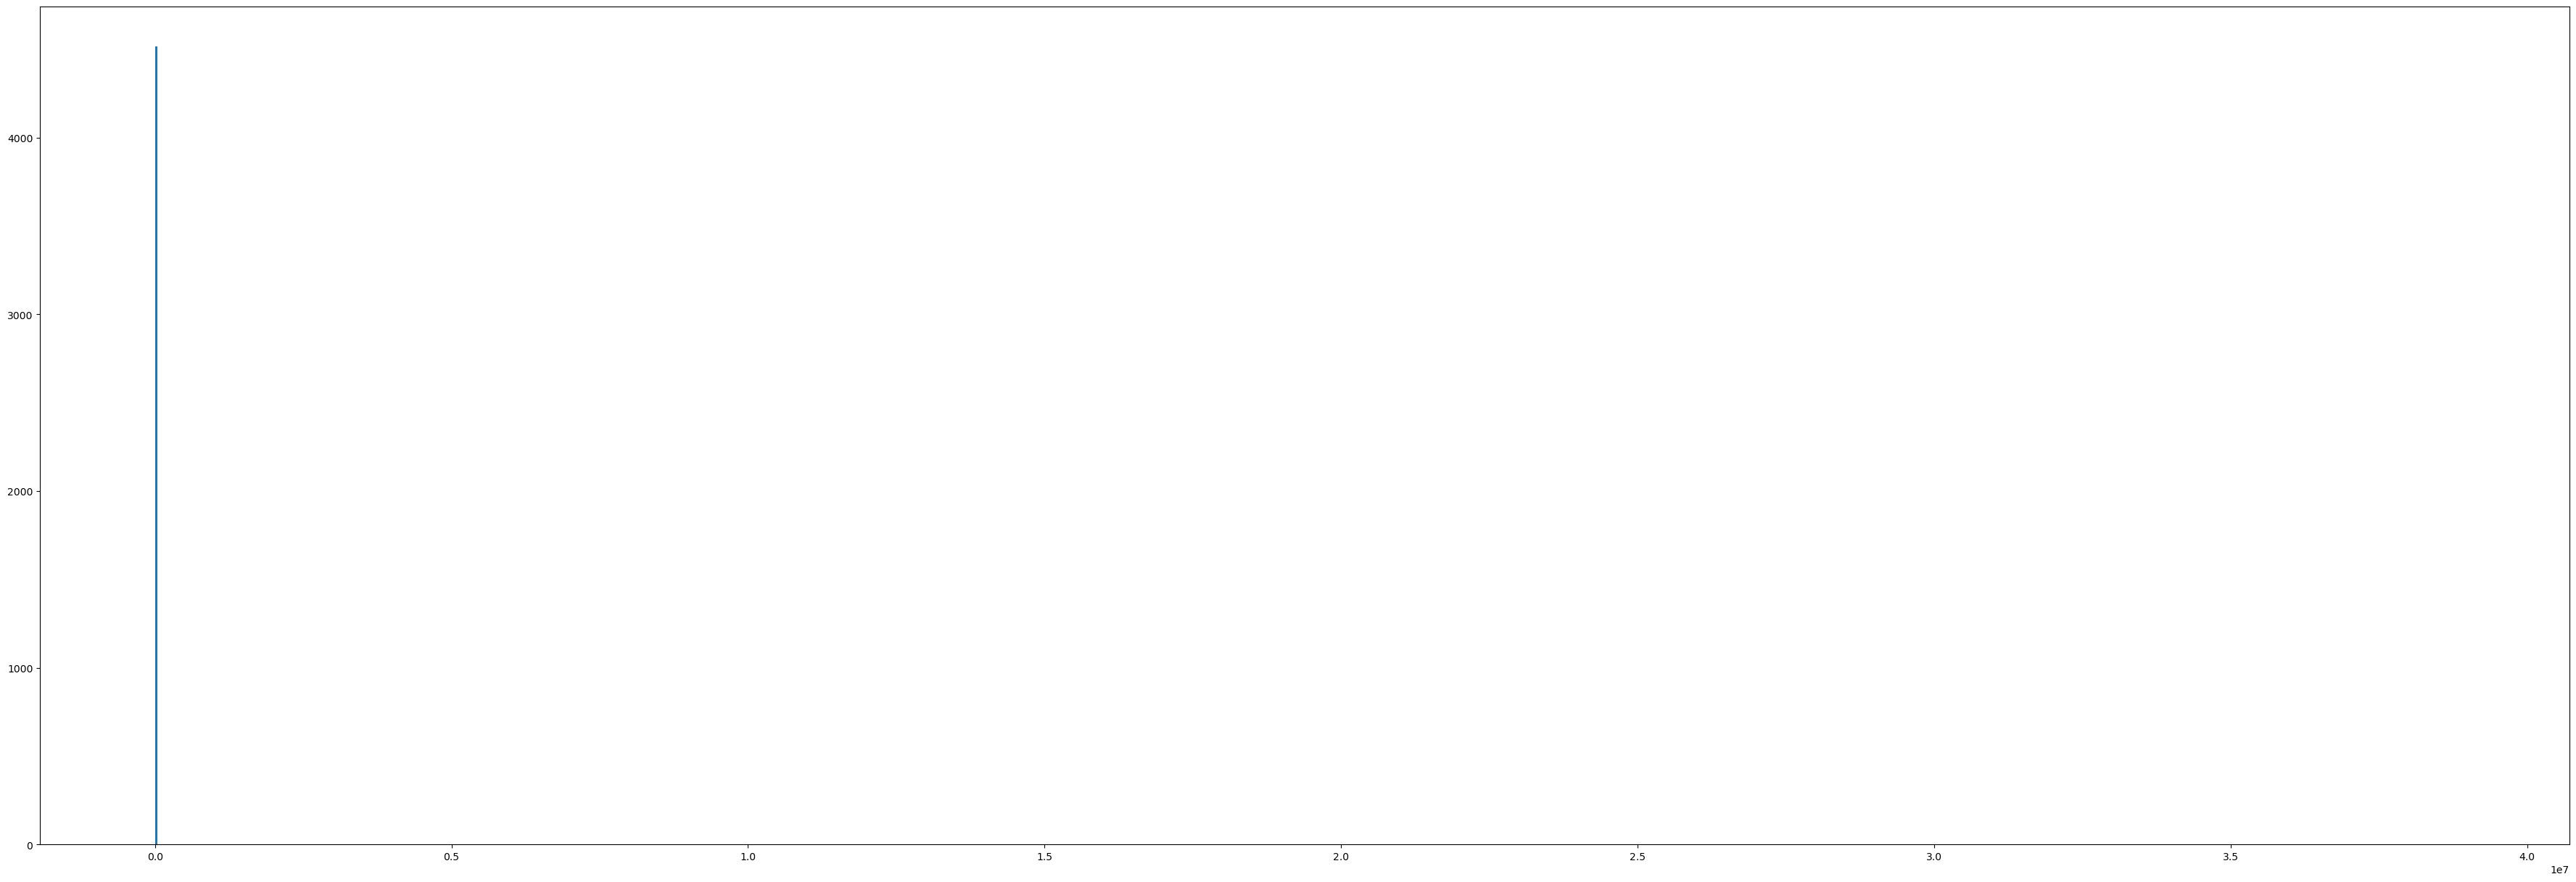

In [59]:
plt.figure(figsize=(45,15))
plt.hist(position_df[(position_df['return_per_day'] != np.inf) & (position_df['return_per_day'] != -np.inf)]['return_per_day'],bins=1000)
plt.show()

### Return per trade

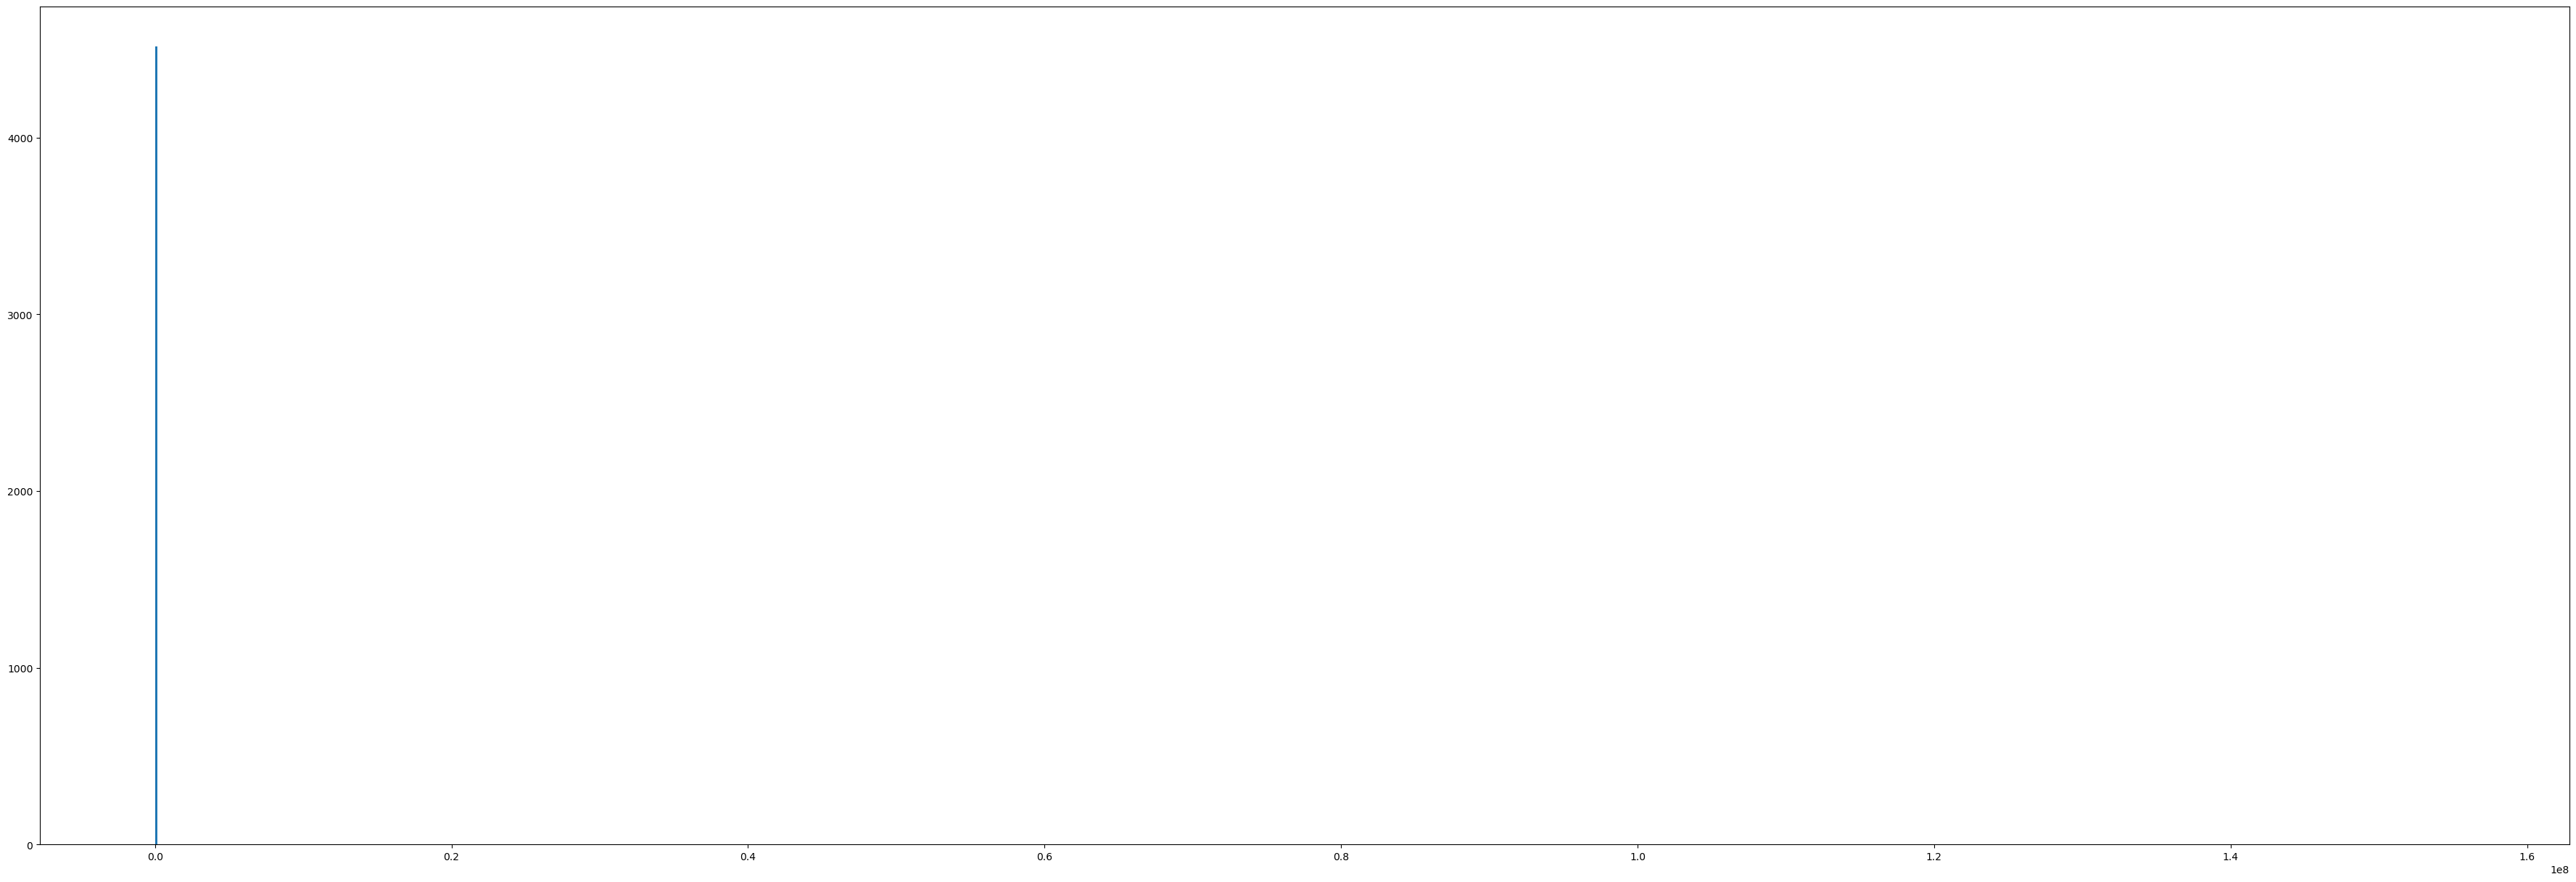

In [60]:
plt.figure(figsize=(45,15))
plt.hist(position_df[(position_df['return'] != np.inf) & (position_df['return'] != -np.inf)]['return'],bins=1000)
plt.show()

In [61]:
np.mean(position_df[(position_df['return'] != np.inf) & (position_df['return'] != -np.inf)]['return'])

34362.19731061625

In [62]:
np.mean(position_df['days_in_trade'])

5.032765109586008

In [63]:
np.std(position_df[(position_df['return'] != np.inf) & (position_df['return'] != -np.inf)]['return'])

2307328.4593972787

In [64]:
# position_df.to_csv(r'test_18_50_200.csv')

### Days in trade

In [65]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

In [66]:
# position_df = pd.read_csv(r'C:\Users\james\OneDrive\Documents\GitHub\jamsydLibrary\approved_projects\interactive_brokers\test_18_50_200.csv')

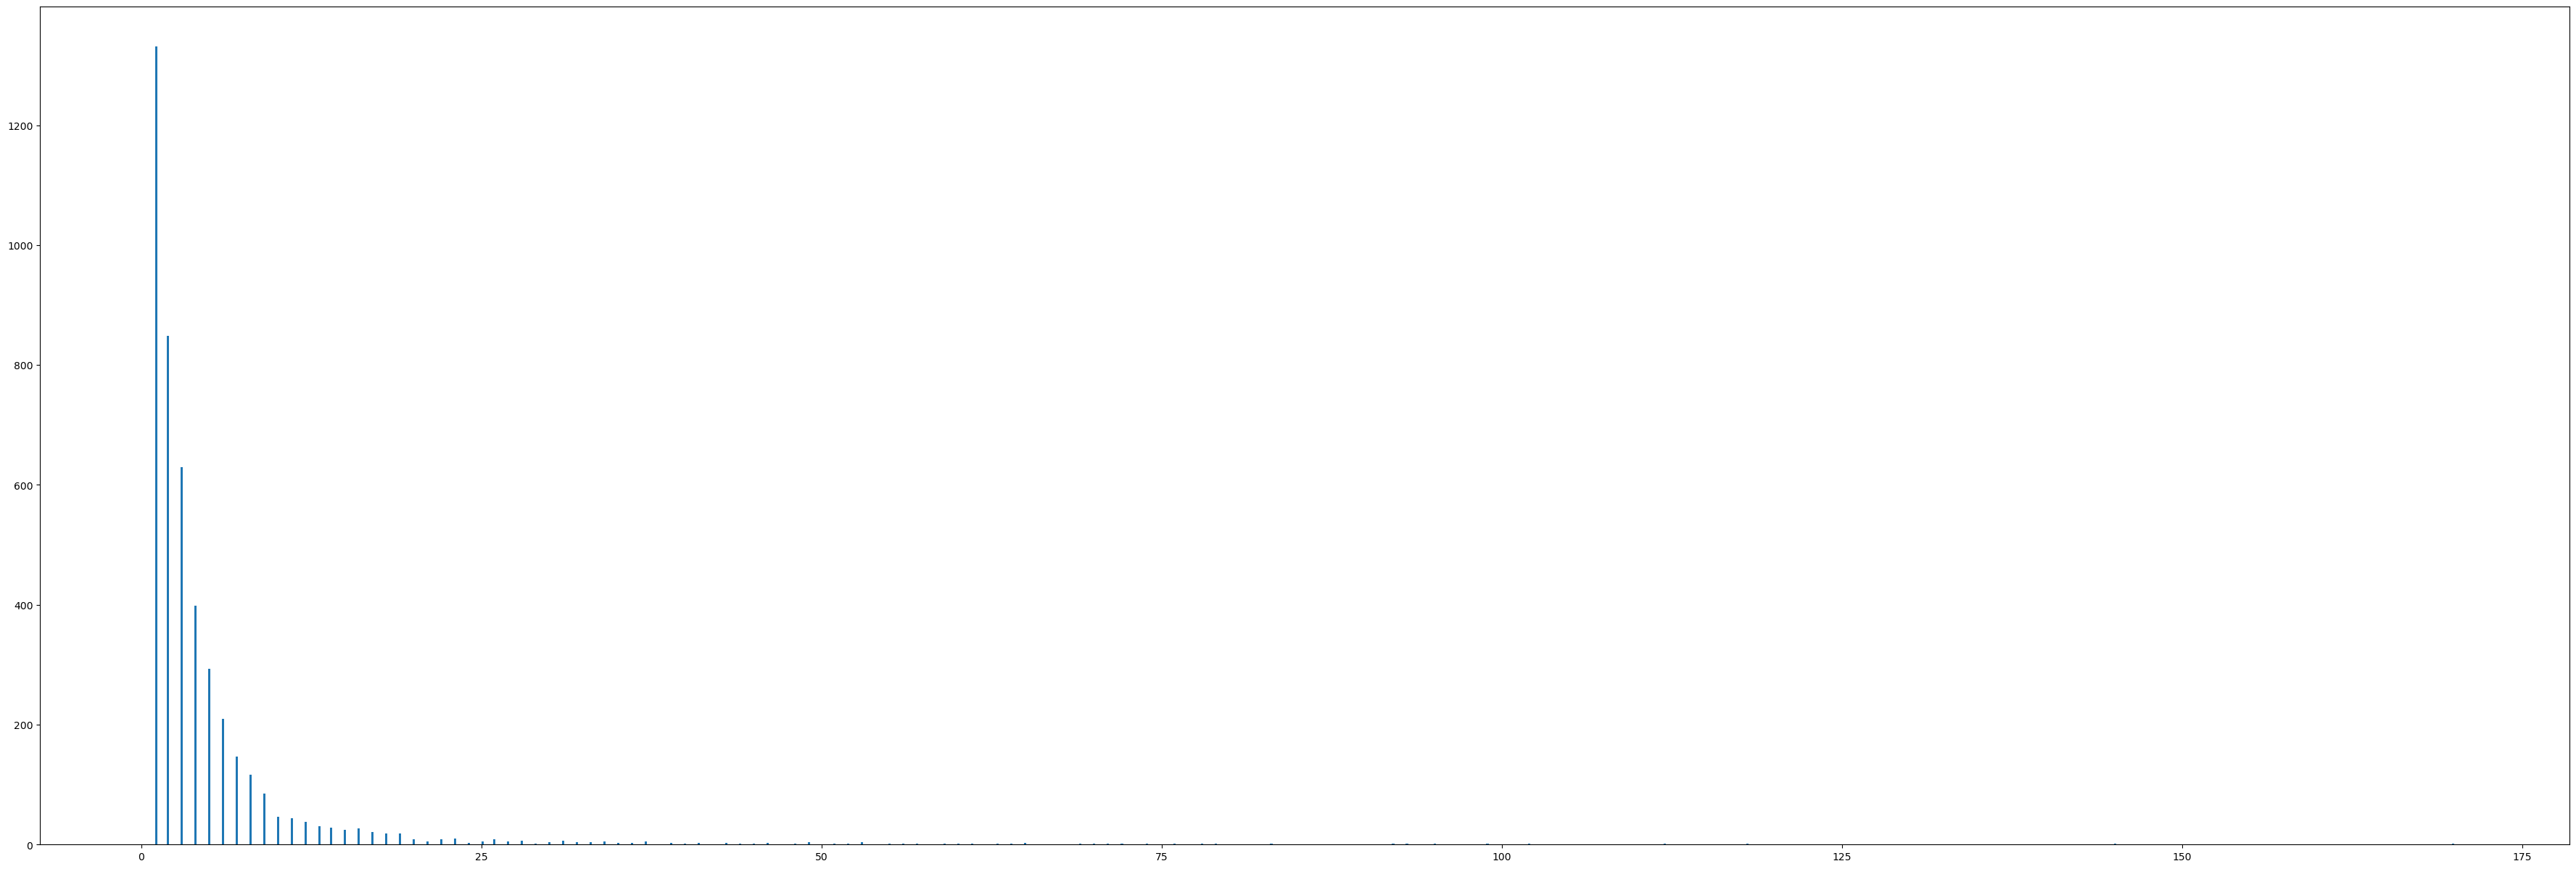

In [67]:
plt.figure(figsize=(45,15))
plt.hist(position_df['days_in_trade'],bins=1000)
plt.show()

### Historical trades

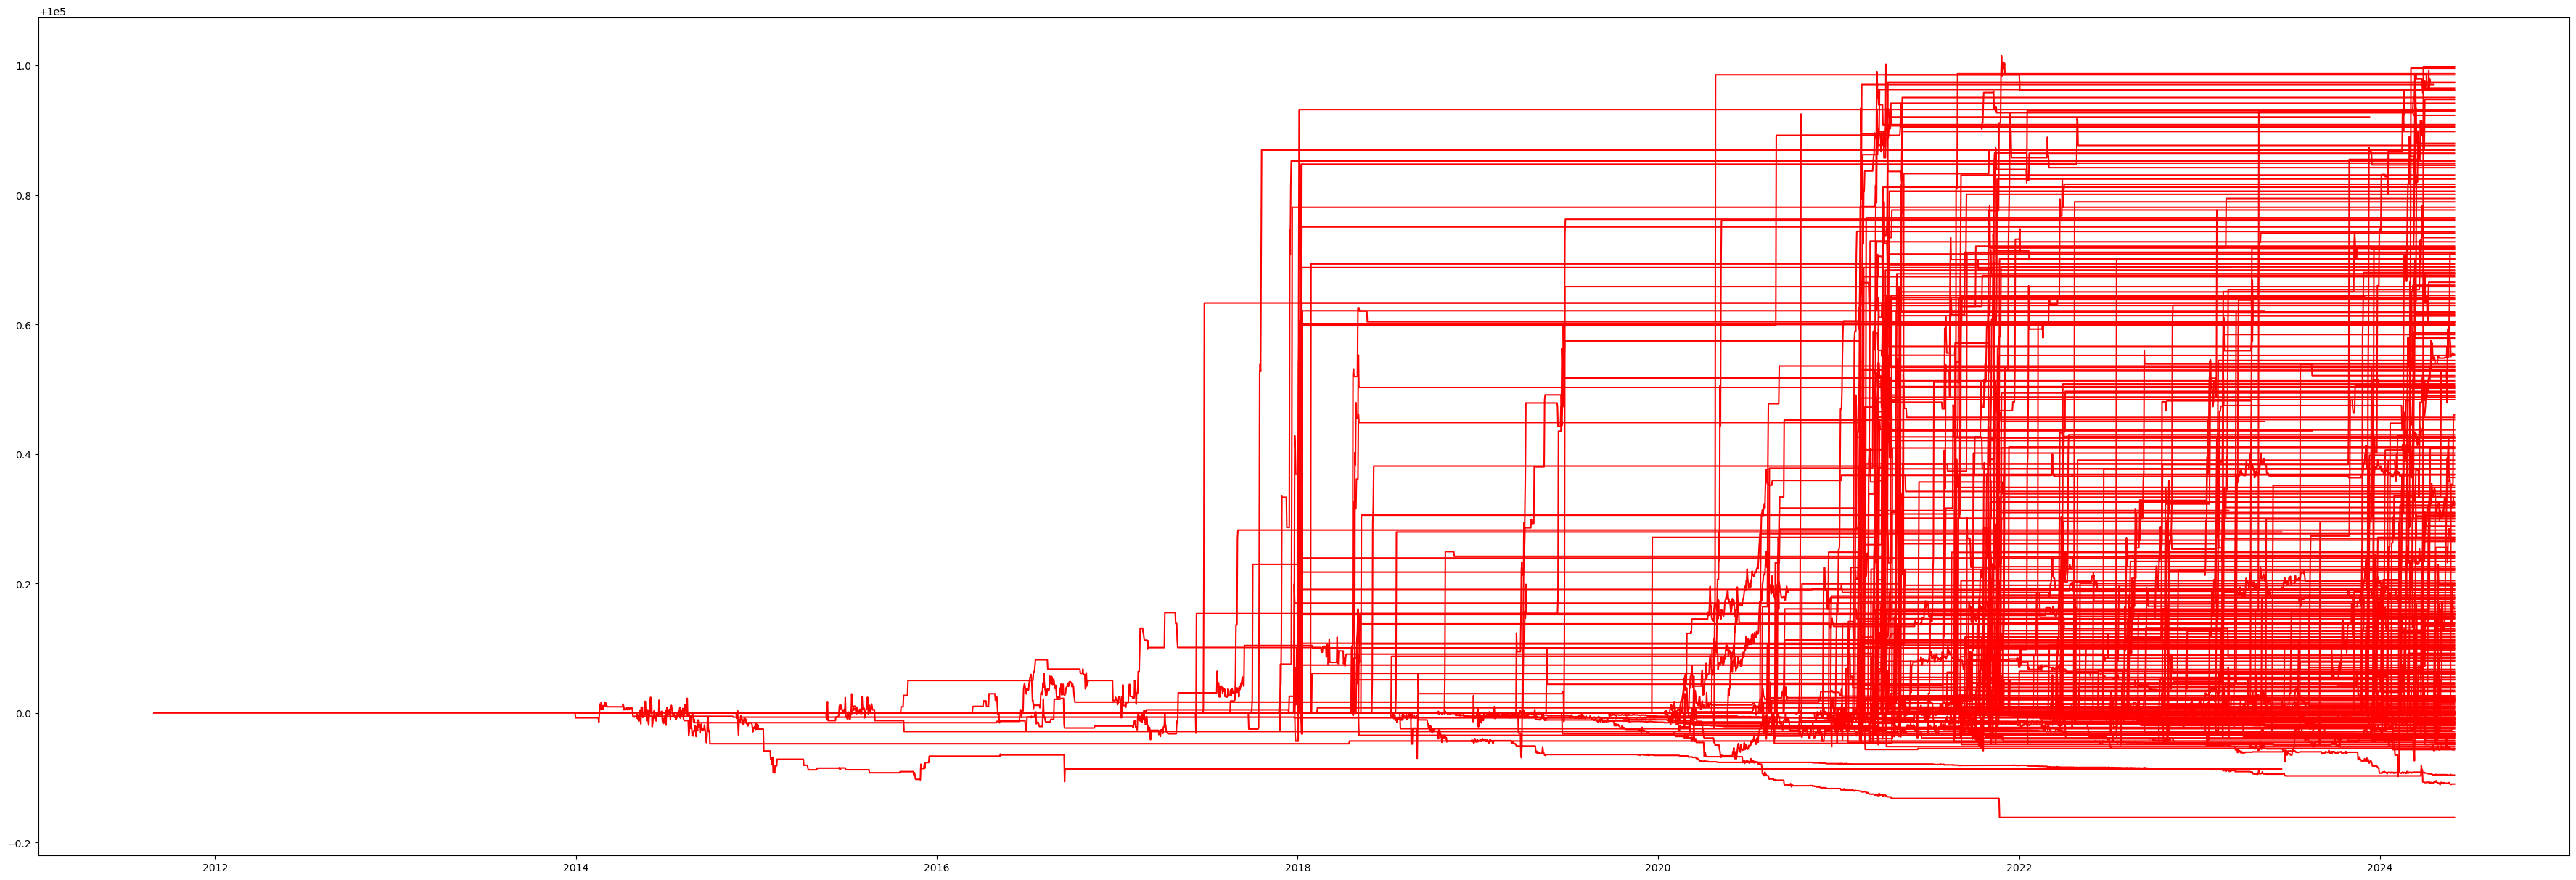

In [97]:
import matplotlib.pyplot as plt

initial_capital = 100000
plt.figure(figsize=(45, 15))
for historical_time_series in historical_data:
    historical_time_series['pnl_vector'] = historical_time_series['pnl'] * historical_time_series['position'] * historical_time_series['position_size']
    if (historical_time_series['pnl_vector'].cumsum().iloc[-1] / initial_capital) < 1:  # This ensures you compare a single value
        plt.plot(initial_capital + historical_time_series['pnl_vector'].cumsum() / initial_capital, color='red')
plt.savefig('test.jpg')
plt.show()

In [69]:
historical_data[0].columns

Index(['ReferenceRate', 'ReferenceRateBTC', 'ReferenceRateETH',
       'ReferenceRateEUR', 'ReferenceRateUSD', 'principal_market_price_usd',
       'principal_market_usd', 'ema', 'ema1', 'ema2', 'pnl', 'ath',
       'ath_drawdown', 'position', 'vector', 'position_size', 'entry_price',
       'pnl_vector'],
      dtype='object')

In [70]:
historical_data[0]['vector'].unique()

array([0,
       'C:\\Users\\james\\OneDrive\\Documents\\GitHub\\jamsydLibrary\\approved_projects\\interactive_brokers\\Data\\crypto_mega\\1cat.csv_2'],
      dtype=object)

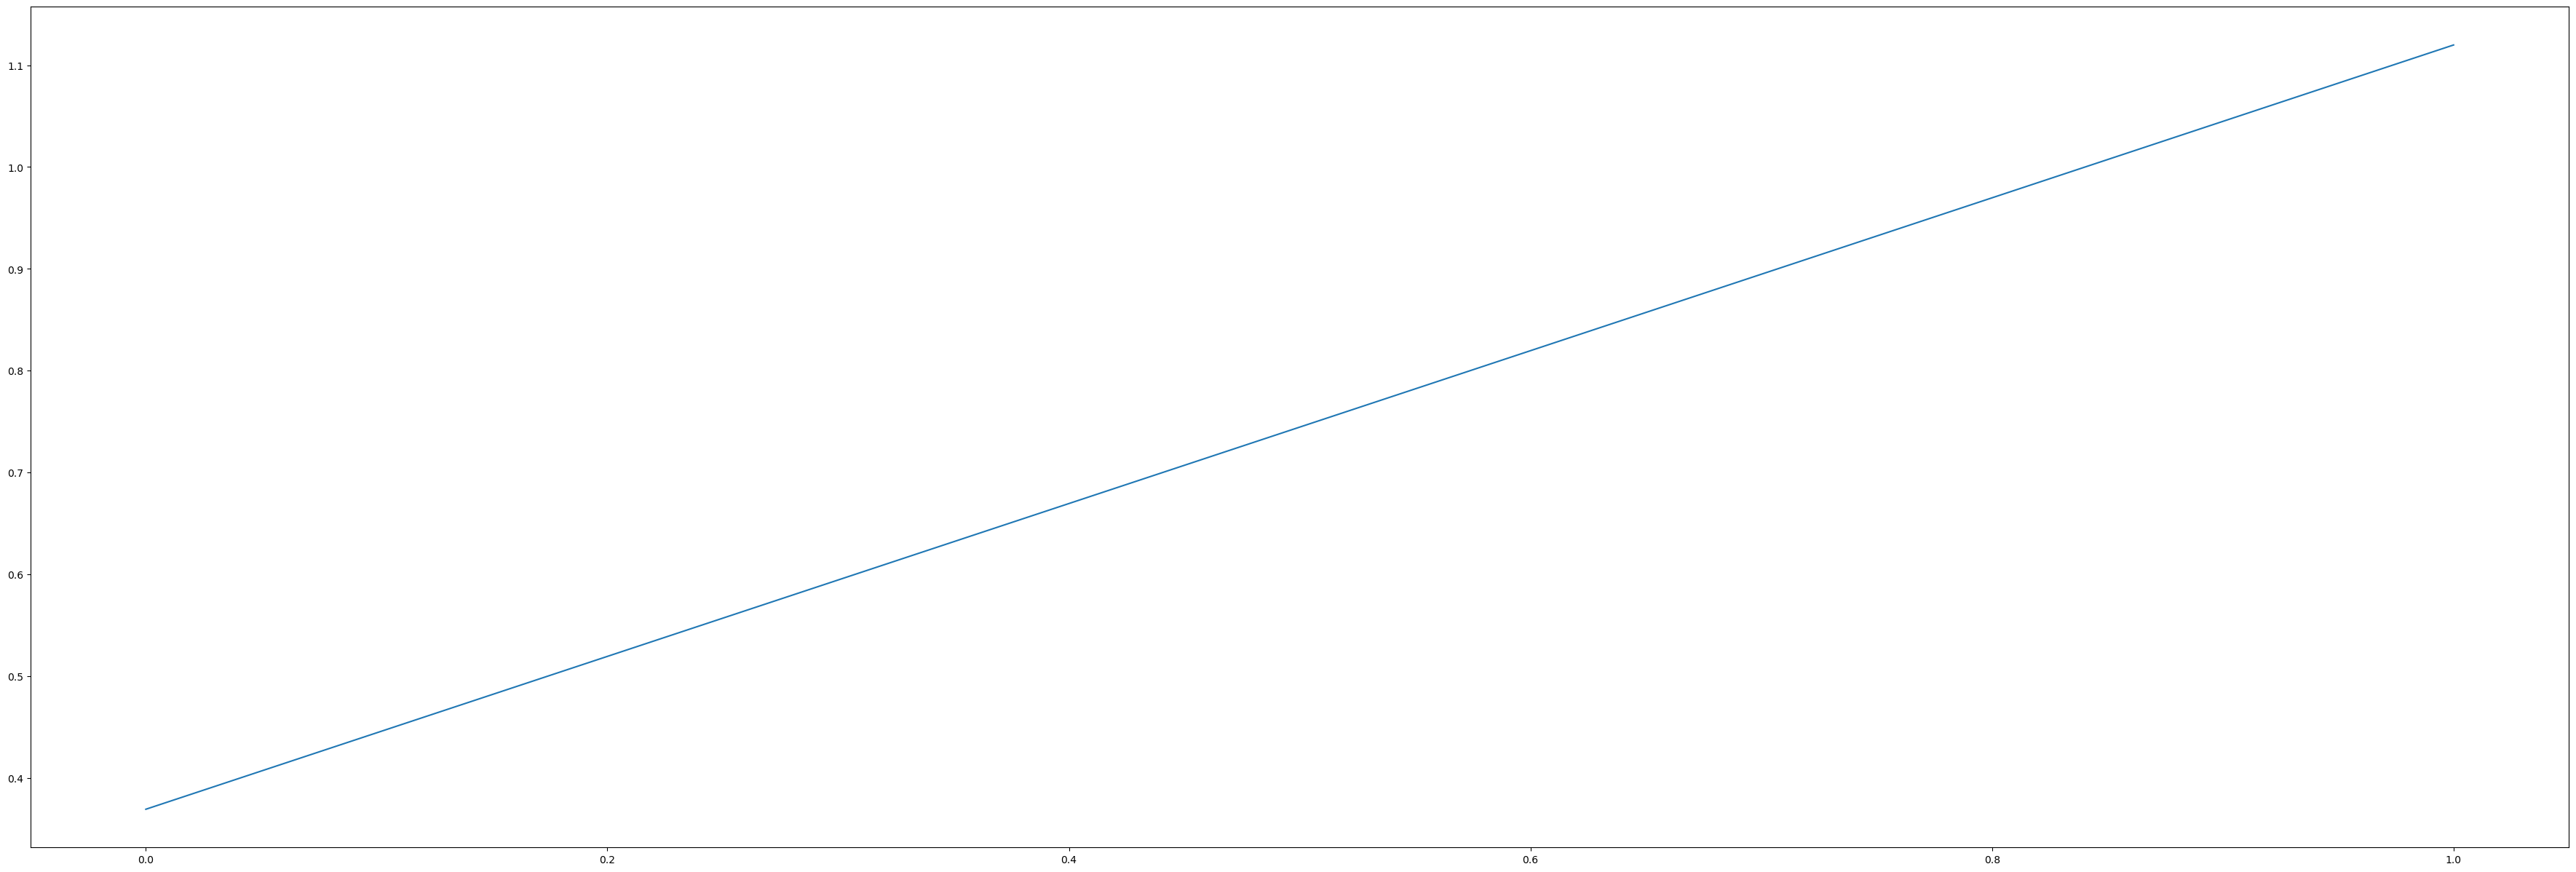

In [71]:
unique_vectors = historical_data[0]['vector'].unique()
plt.figure(figsize=(45,15))
for position in unique_vectors[1:]:
    pnl_vector = historical_data[0][historical_data[0]['vector'] == position]['pnl'].cumsum()/historical_data[0][historical_data[0]['vector'] == position]['entry_price']
    pnl_vector = pnl_vector.reset_index()[0]
    
    plt.plot(pnl_vector.reset_index()[0])

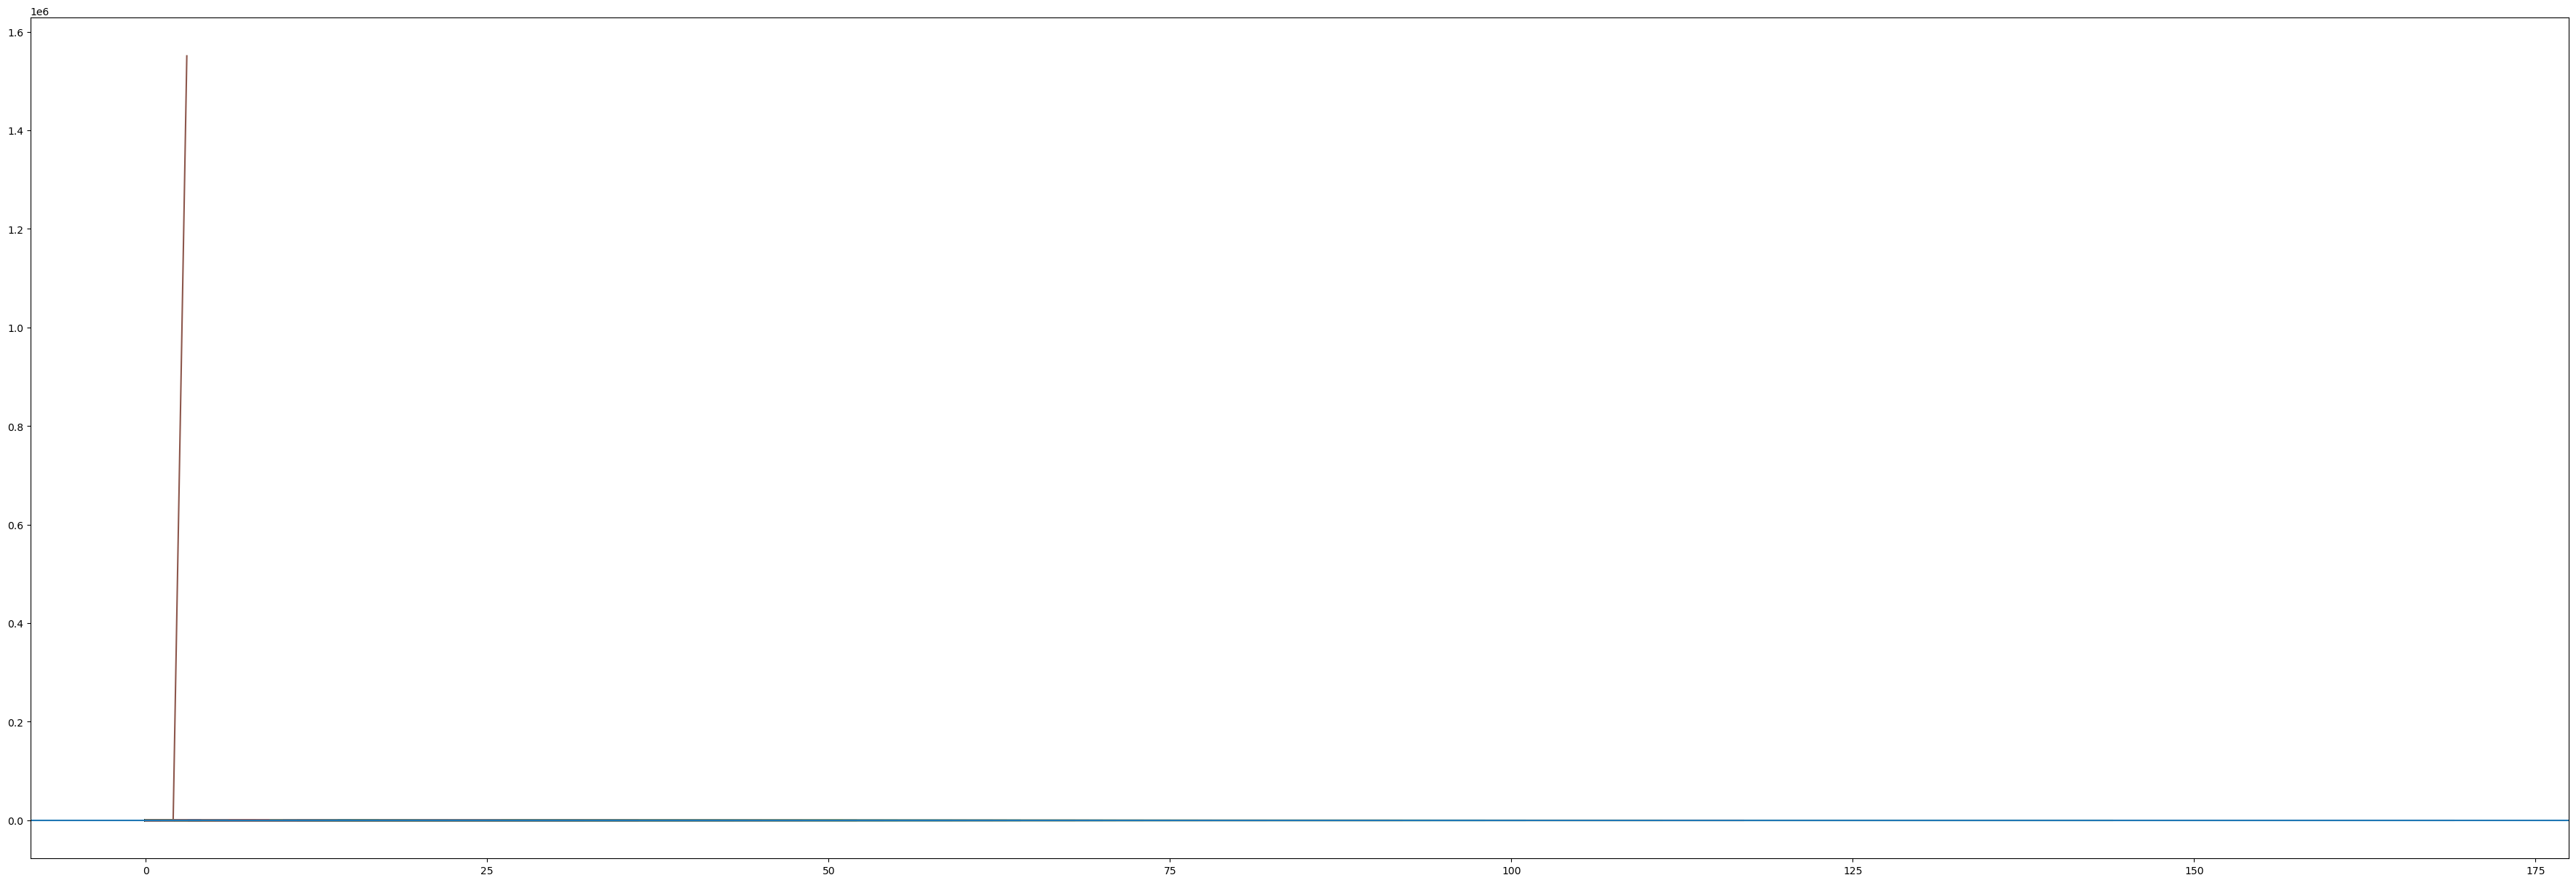

In [72]:
initial_capital = 100000
nine_day_pnl    = []
plt.figure(figsize=(45,15))
for historical_time_series in historical_data:
    historical_time_series['pnl_vector'] = historical_time_series['pnl']*historical_time_series['position']*historical_time_series['position_size']

    # Unique vectors
    unique_vectors = historical_time_series['vector'].unique()

    for position in unique_vectors[1:]:
        pnl_vector = historical_time_series[historical_time_series['vector'] == position]['pnl'].cumsum()/historical_time_series[historical_time_series['vector'] == position]['entry_price']

        plt.plot(pnl_vector.reset_index()[0])
        nine_day_pnl.append(pnl_vector.reset_index()[0].to_list())
plt.axhline(-0.05)
plt.show()


In [73]:
nine_day_pnl_df = pd.DataFrame(nine_day_pnl)

In [74]:
nine_day_pnl_df_mean    = nine_day_pnl_df.mean(axis=0)
nine_day_pnl_df_std     = nine_day_pnl_df.std(axis=0)
nine_day_pnl_df_median  = nine_day_pnl_df.median(axis=0)



In [75]:
nine_day_pnl_df

,0,1,2,3,4,5,6,7,8,9,...,160,161,162,163,164,165,166,167,168,169
0,0.369182,1.119843,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.069671,0.432827,0.576519,0.589267,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.118384,0.154379,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.110490,0.092487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.015353,0.114069,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4512,0.239094,0.982681,4.475801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4513,-0.034390,-0.012563,0.079532,0.153435,0.219023,0.482555,0.492364,1.20975,1.336381,1.390121,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4514,0.059348,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4515,0.114877,0.502198,0.594258,0.873334,0.866539,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
import pandas as pd
import numpy as np
from scipy import stats

# Load your DataFrame
# nine_day_pnl_df = pd.read_csv('/mnt/data/your_dataframe.csv')  # Replace with the actual path to your DataFrame

confidence_level = 0.95
degrees_freedom = nine_day_pnl_df.shape[0] - 1
confidence_intervals = {}

for column in nine_day_pnl_df.columns:
    column_data = nine_day_pnl_df[column].dropna()
    if len(column_data) > 1:  # Ensure there is enough data to calculate statistics
        mean = column_data.mean()
        sem = stats.sem(column_data)  # Standard error of the mean
        confidence_interval = stats.t.interval(confidence_level, degrees_freedom, loc=mean, scale=sem)
        confidence_intervals[column] = confidence_interval

# Convert the dictionary to a DataFrame for better visualization
confidence_intervals_df = pd.DataFrame(confidence_intervals, index=['Lower Bound', 'Upper Bound'])
print(confidence_intervals_df)


                  0         1         2            3         4         5    \
Lower Bound  0.071385  0.132754  0.190422  -871.908166  0.237692  0.237657   
Upper Bound  0.081052  0.152477  0.225415  2688.413130  0.290036  0.304182   

                  6         7         8         9    ...       135       136  \
Lower Bound  0.219871  0.219678  0.221948  0.187048  ... -0.022263 -0.025462   
Upper Bound  0.292360  0.316236  0.382069  0.307715  ...  0.074130  0.074963   

                  137       138       139       140       141       142  \
Lower Bound -0.027940 -0.026061 -0.030683 -0.028381 -0.027387 -0.032454   
Upper Bound  0.076309  0.074941  0.081673  0.082748  0.085690  0.087896   

                  143       144  
Lower Bound -0.028581 -0.031935  
Upper Bound  0.082192  0.084827  

[2 rows x 145 columns]


In [77]:
confidence_intervals_df.T['Lower Bound']

0        0.071385
1        0.132754
2        0.190422
3     -871.908166
4        0.237692
          ...    
140     -0.028381
141     -0.027387
142     -0.032454
143     -0.028581
144     -0.031935
Name: Lower Bound, Length: 145, dtype: float64

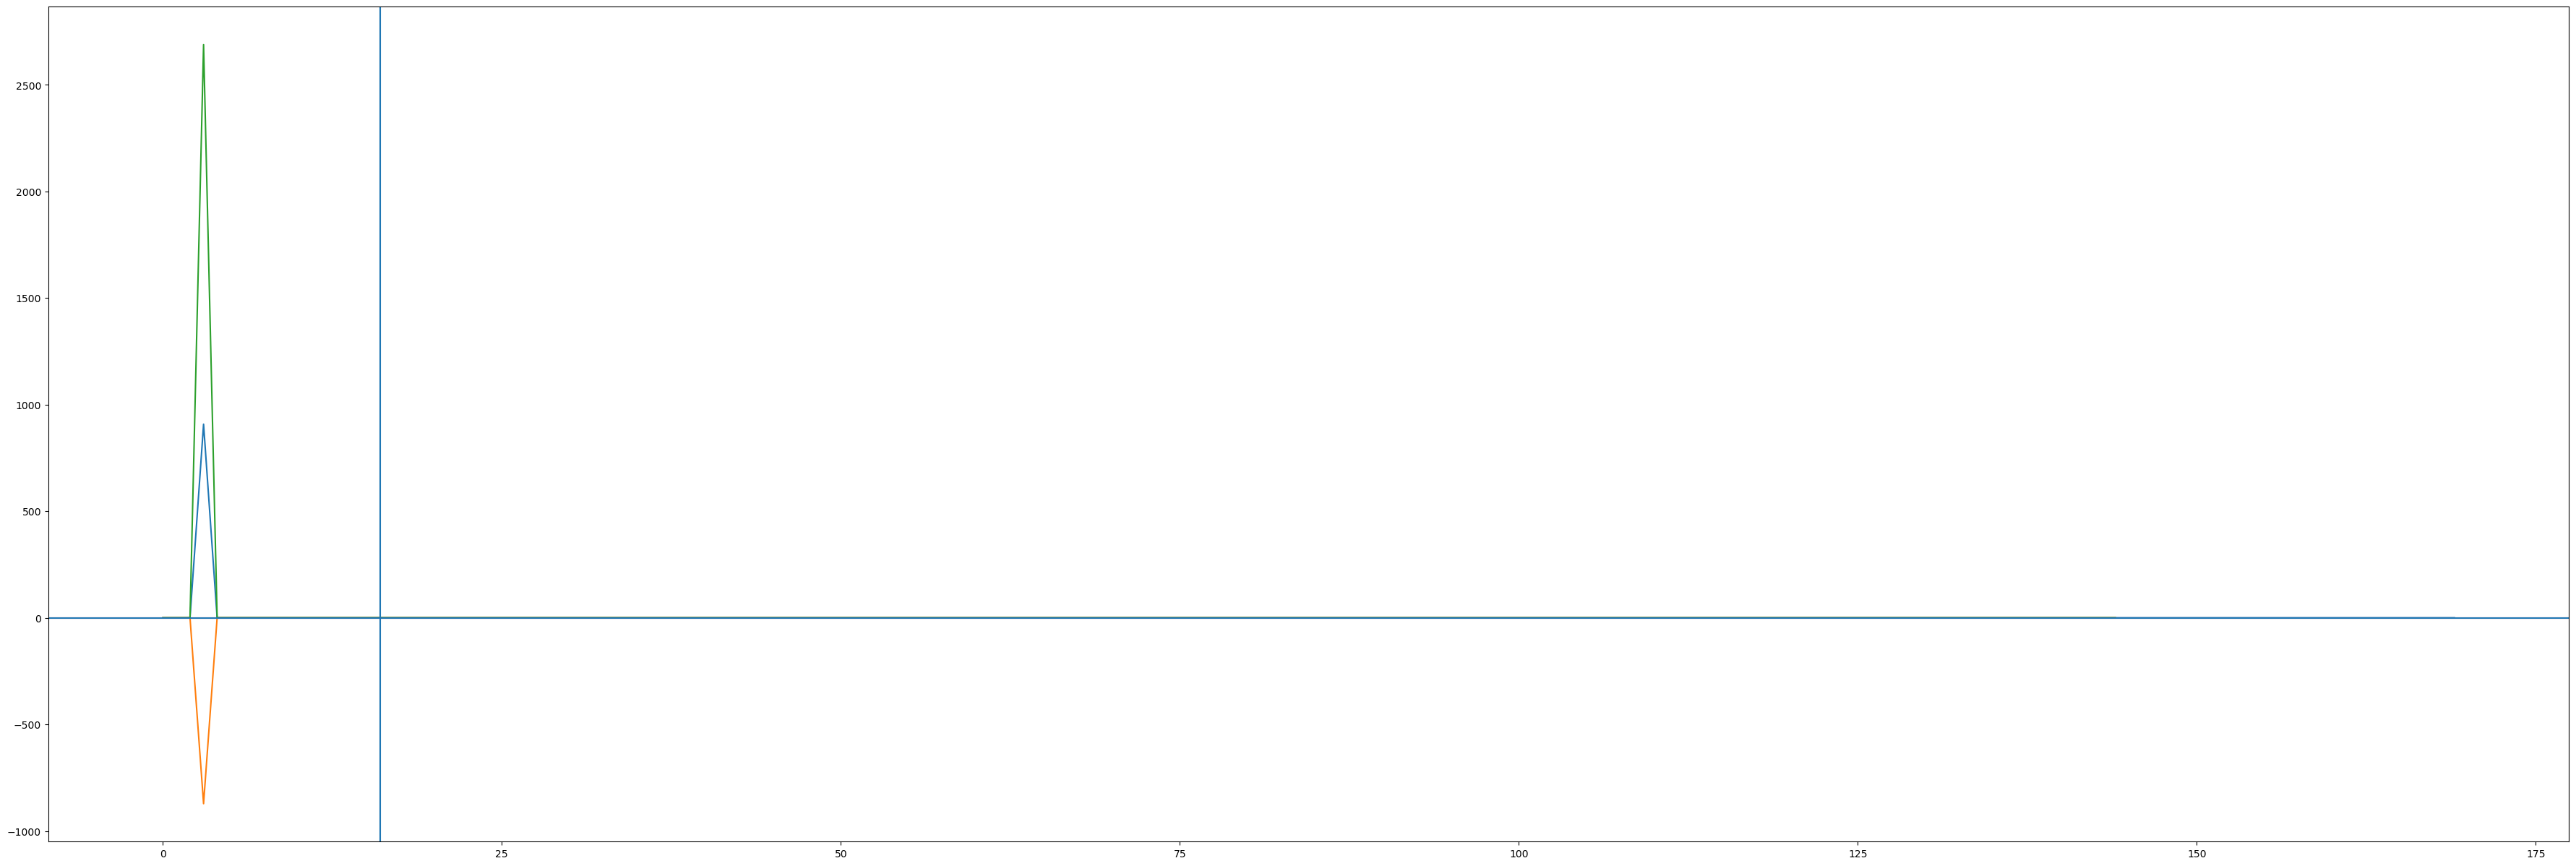

In [78]:
plt.figure(figsize=(45,15))
plt.plot(nine_day_pnl_df_mean)
plt.plot(confidence_intervals_df.T['Lower Bound'])
plt.plot(confidence_intervals_df.T['Upper Bound'])
# plt.plot(nine_day_pnl_df_median,color='pink')
plt.axhline(0,color='red')
plt.axhline(0.05)
plt.axvline(16)

plt.show()

In [79]:
nine_day_pnl_df_mean.to_csv('mean.csv')

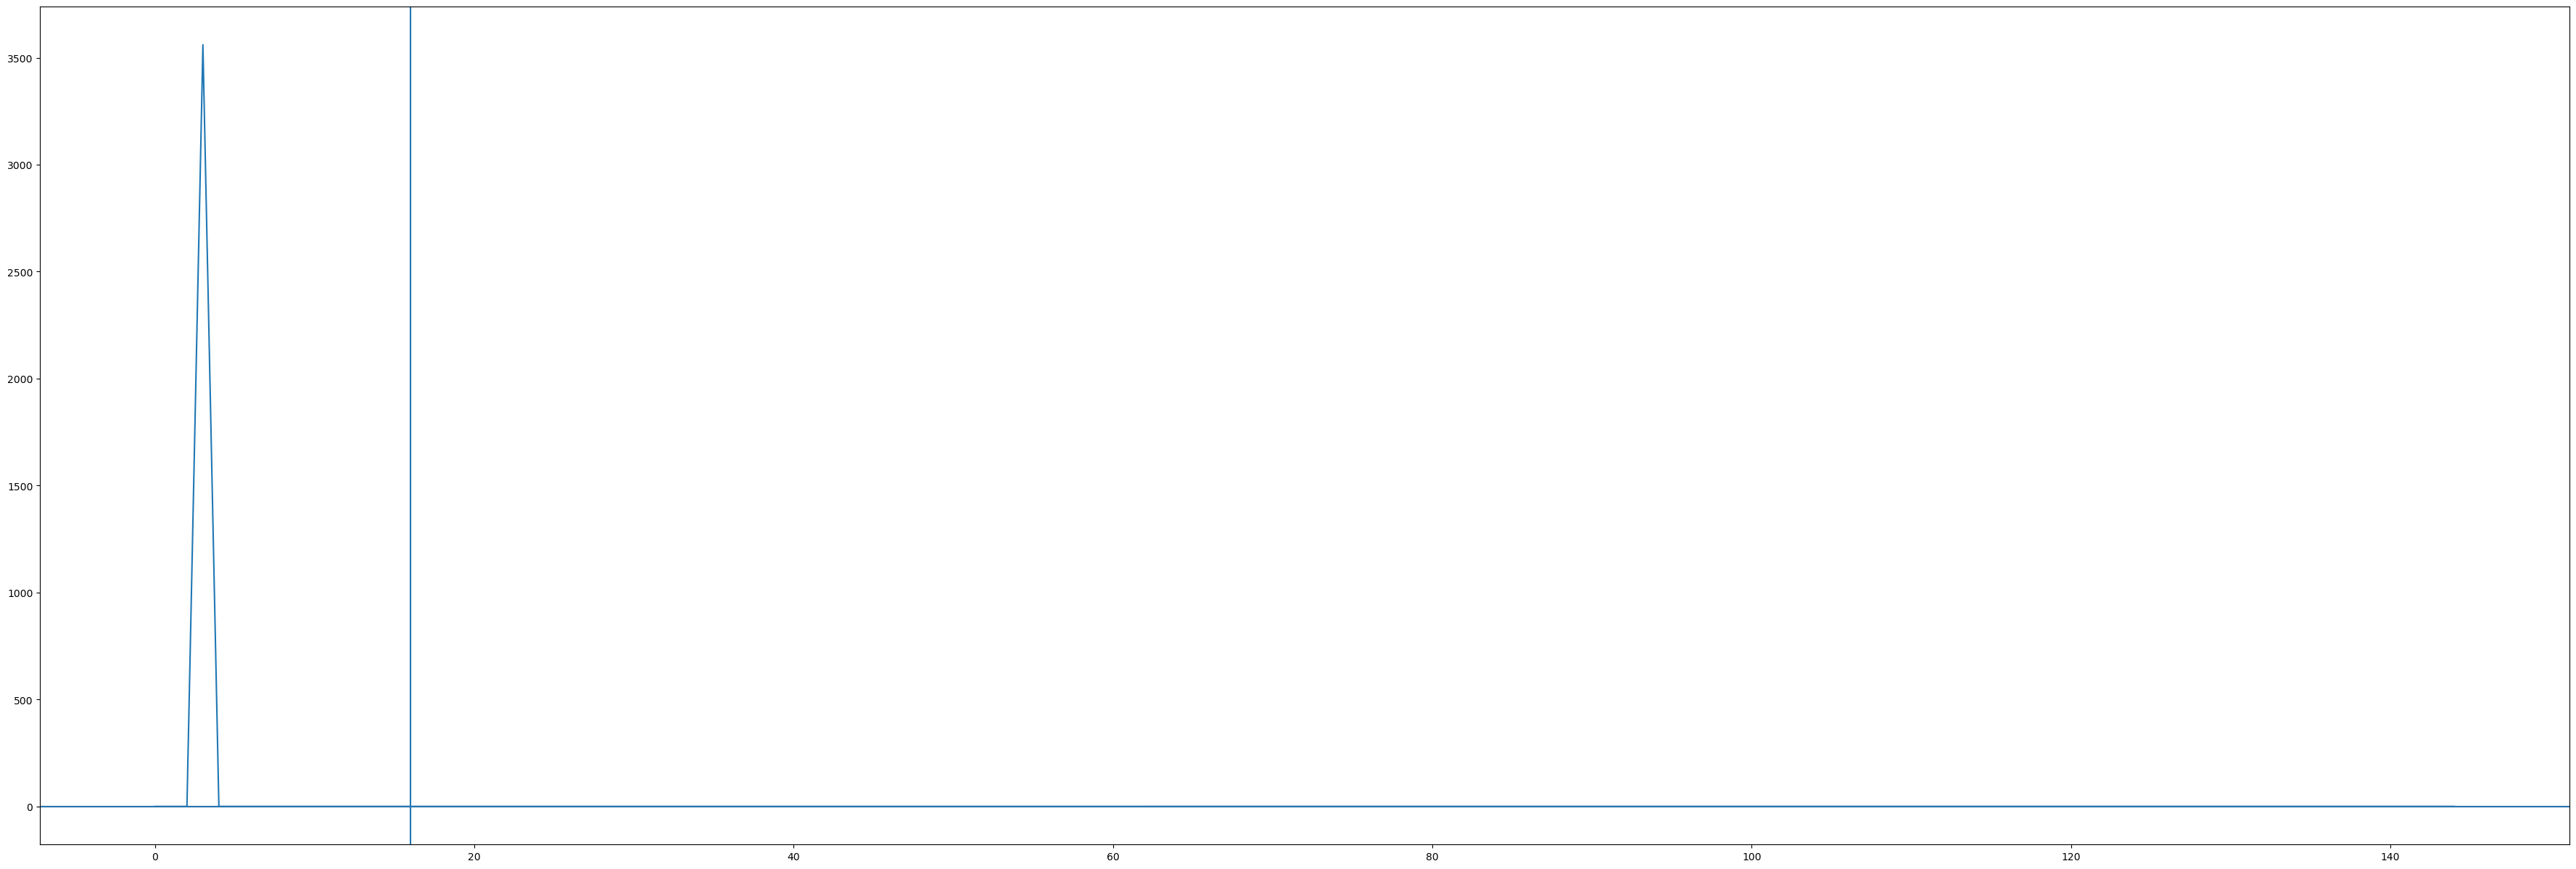

In [80]:
test = confidence_intervals_df.T.copy()
test['Spread'] = test['Upper Bound'] - test['Lower Bound']

plt.figure(figsize=(45,15))
plt.plot(test['Spread'])
plt.axhline(0,color='red')
plt.axhline(0.05)
plt.axvline(16)

plt.show()

In [81]:
len(nine_day_pnl)

4517

In [82]:
historical_time_series

,ReferenceRate,ReferenceRateUSD,principal_market_price_usd,principal_market_usd,ema,ema1,ema2,pnl,ath,ath_drawdown,position,vector,position_size,entry_price,pnl_vector
time,,,,,,,,,,,,,,,
2023-10-17,0.015422,0.015422,NaN,NaN,0.015422,0.015422,0.015422,NaN,NaN,NaN,0,0,0.0,0.0,NaN
2023-10-18,0.012658,0.012658,NaN,NaN,0.015131,0.015313,0.015394,-0.002763,0.015422,0.820807,0,0,0.0,0.0,-0.0
2023-10-19,0.012167,0.012167,NaN,NaN,0.014819,0.015190,0.015362,-0.000491,0.015422,0.788983,0,0,0.0,0.0,-0.0
2023-10-20,0.010811,0.010811,NaN,NaN,0.014397,0.015018,0.015317,-0.001356,0.015422,0.701032,0,0,0.0,0.0,-0.0
2023-10-21,0.011502,0.011502,NaN,NaN,0.014092,0.014880,0.015279,0.000691,0.015422,0.745832,0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-27,0.012324,0.012324,0.012332,mexc-ztx_ztx-usdt-spot,0.013102,0.015072,0.019287,-0.000411,0.036365,0.338891,0,0,0.0,0.0,-0.0
2024-05-28,0.013082,0.013082,0.013129,gate.io-ztx_ztx-usdt-spot,0.013100,0.014994,0.019225,0.000759,0.036365,0.359750,0,0,0.0,0.0,0.0
2024-05-29,0.015128,0.015128,0.014913,mexc-ztx_ztx-usdt-spot,0.013313,0.014999,0.019184,0.002045,0.036365,0.415993,0,0,0.0,0.0,0.0


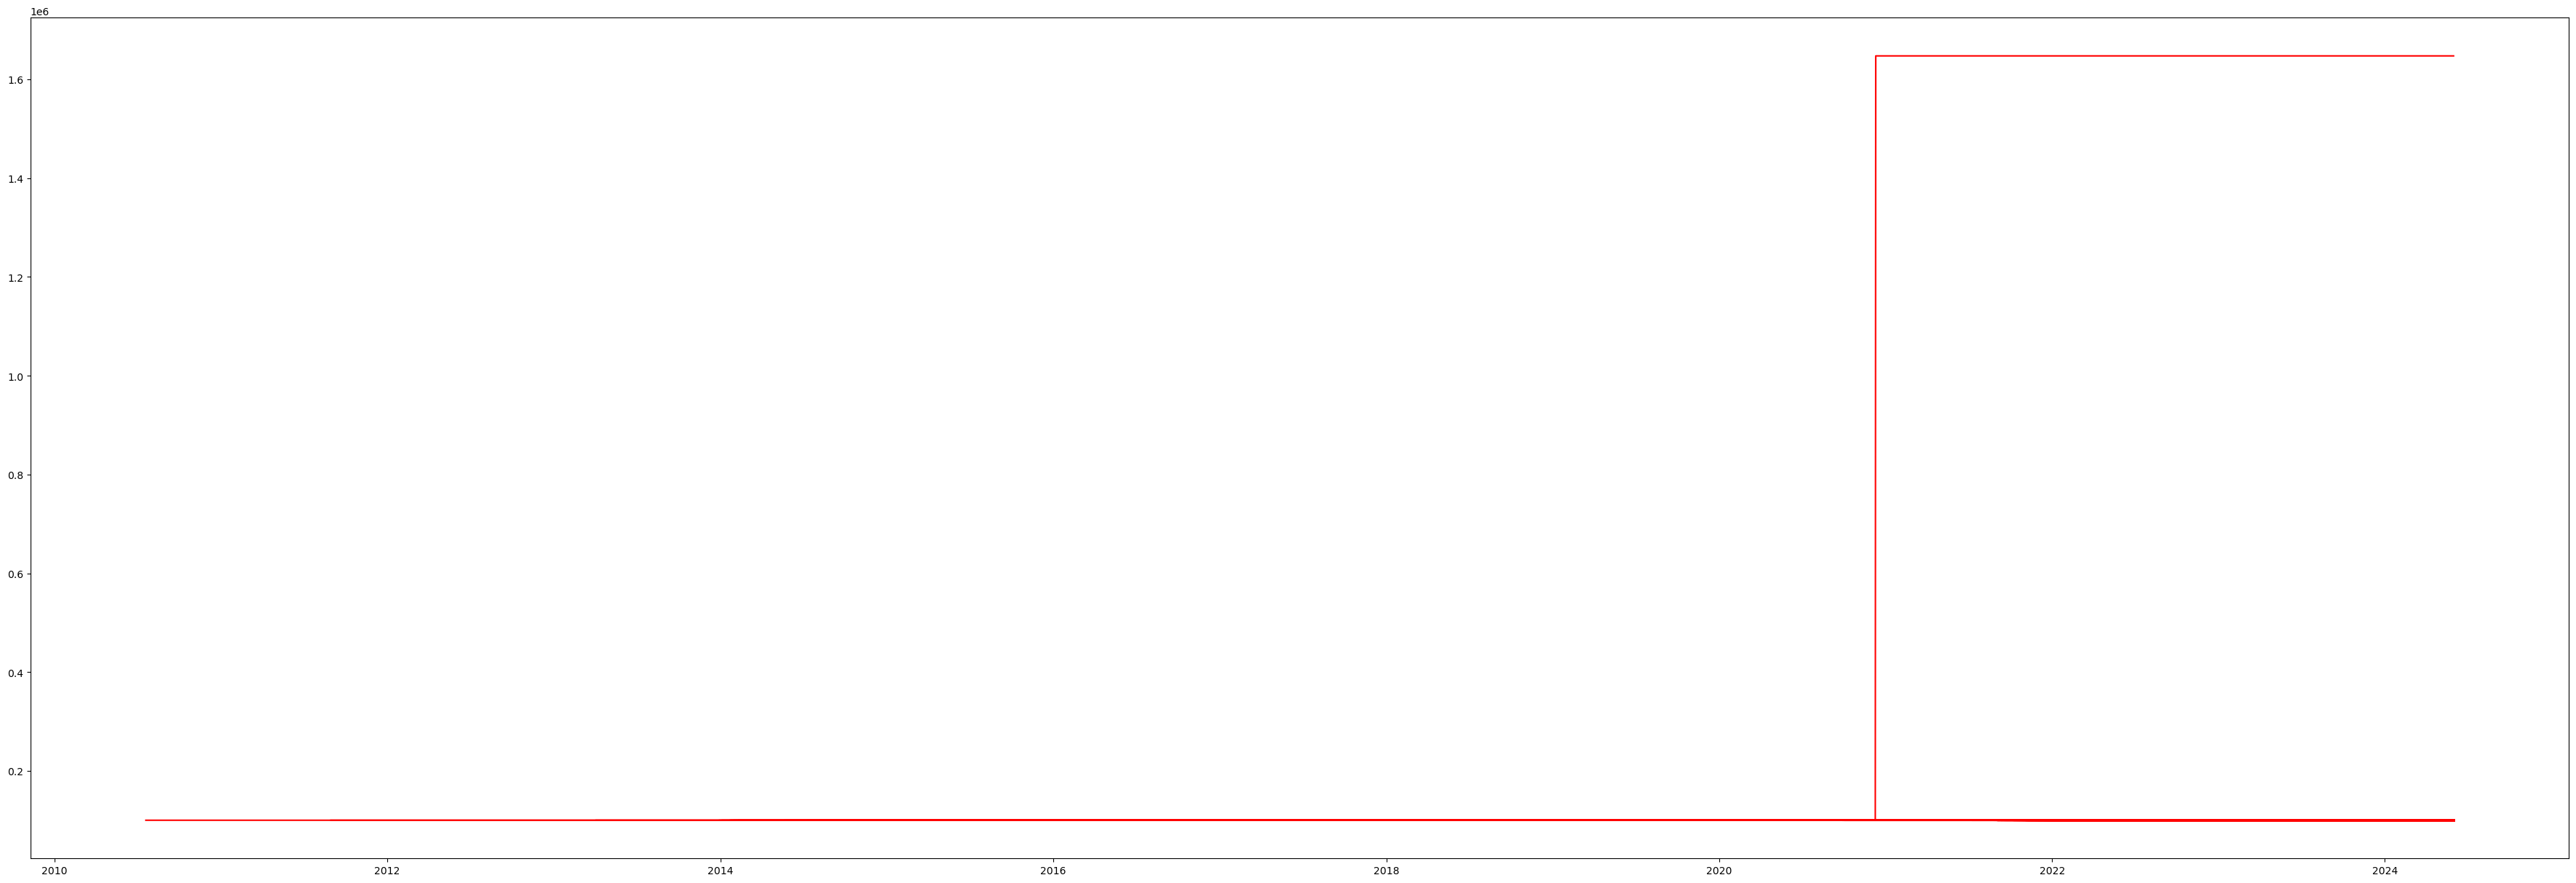

In [83]:
initial_capital = 100000
plt.figure(figsize=(45,15))
for historical_time_series in historical_data:
    historical_time_series['pnl_vector'] = historical_time_series['pnl']*historical_time_series['position']*historical_time_series['position_size']
    # for historical_time_series['vector']:
    plt.plot(initial_capital + historical_time_series['pnl_vector'].cumsum()/initial_capital,color='red')
plt.savefig('test.jpg')
plt.show()


In [84]:
initial_capital = 100000
historical_returns_profile = []
for historical_time_series in historical_data:
    historical_time_series['pnl_vector'] = historical_time_series['pnl']*historical_time_series['position']*historical_time_series['position_size']
    returns = initial_capital + historical_time_series['pnl_vector'].cumsum()
    historical_returns_profile.append((returns.iloc[-1])/initial_capital)


In [85]:
print(historical_returns_profile)

[2.119843423850964, 1.9501789795895927, 3.205434385949257, 1.904772545141303, 1.7086834960322128, 1.0, 2.049219875498216, 1.146438446439702, 2.3942174555321665, 1.0, 1.0, 1.7623632760981718, 3.076016948643045, 1.0, 1.0, 3.2552023776779424, 1.0213940619145332, 1.0798212269399239, 1.0, 1.0622925785228154, 1.533971420082635, 1.0021631971582072, 2.3008218887341387, 1.2678008854632272, 1.0, 1.9296261619305541, 1.6877262284428645, 1.0, 1.0, 1.578812054986216, 1.7085551967114572, 1.1223799548858233, 1.512936885995386, 1.8642836999200558, 1.0, 2.055329207111637, 1.1819794560183645, 2.5611578590145836, 4.533795086429829, 1.0198848855388079, 2.2444075577225133, 3.7060881669596046, 1.2767701161800127, 1.0, 1.0, 1.0, 3.9135184403747423, 1.961350480102378, 2.5744623054128084, 1.3903283089681817, 1.603743902699864, 1.115959723471803, 1.4901238198194646, 1.0, 3.8569168324963603, 1.1280392526684841, 5.4035832136762005, 1.0014412542575817, 2.371954788448972, 2.6519496988132687, 2.1210915801920787, 1.27

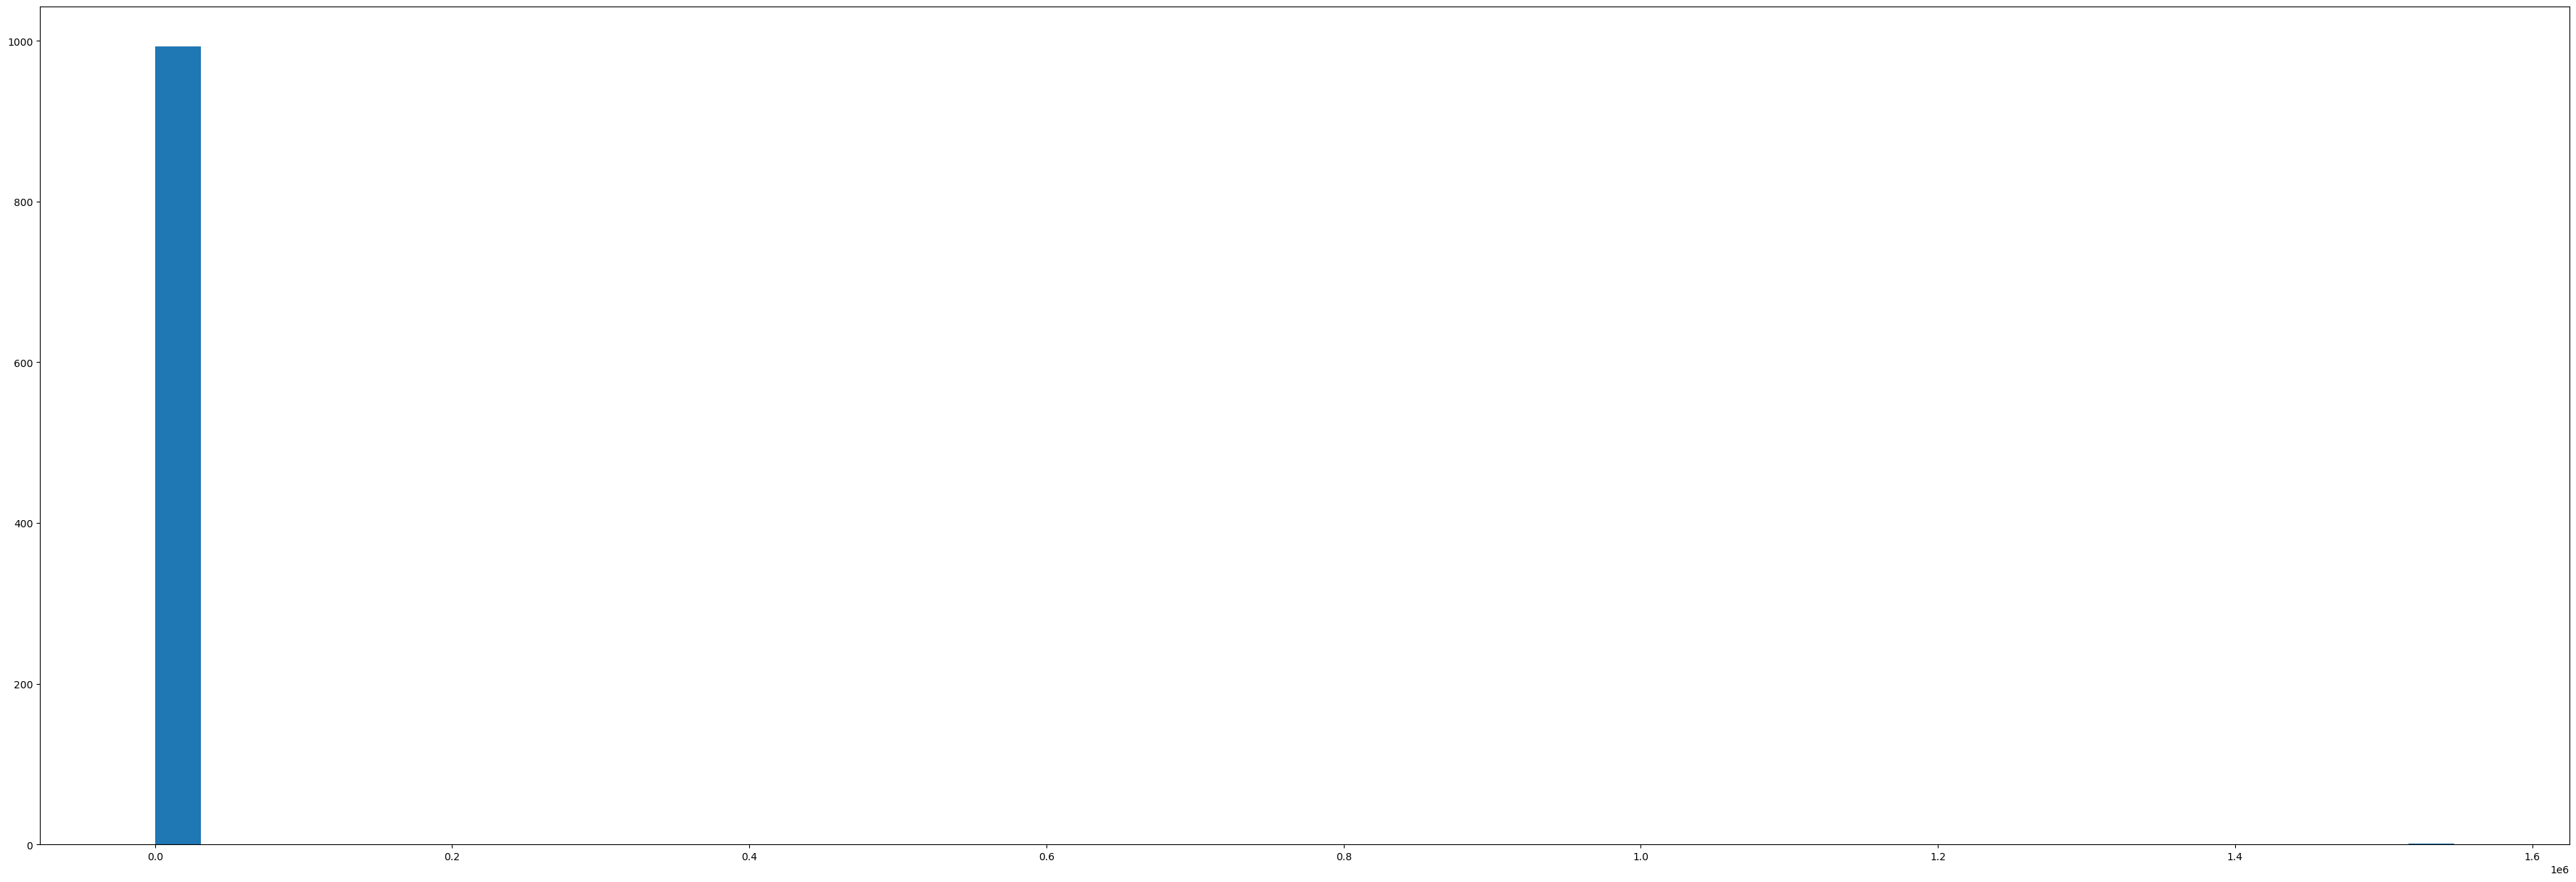

In [86]:
plt.figure(figsize=(45,15))
plt.hist(historical_returns_profile,bins=50)
plt.show()

# Drawdown Analytics

In [87]:
def rolling_max_drawdown(series, window=252):
    """
    Calculate the rolling maximum drawdown for a given series and window.
    """
    roll_max = series.rolling(window, min_periods=1).max()
    drawdown = series / roll_max - 1.0
    max_drawdown = drawdown.rolling(window, min_periods=1).min()

    return max_drawdown


In [88]:
# Assuming your DataFrame is named time_series and has the column 'close'
time_series['rolling_max_drawdown'] = rolling_max_drawdown(initial_capital + time_series['pnl_vector'].cumsum(), window=252)

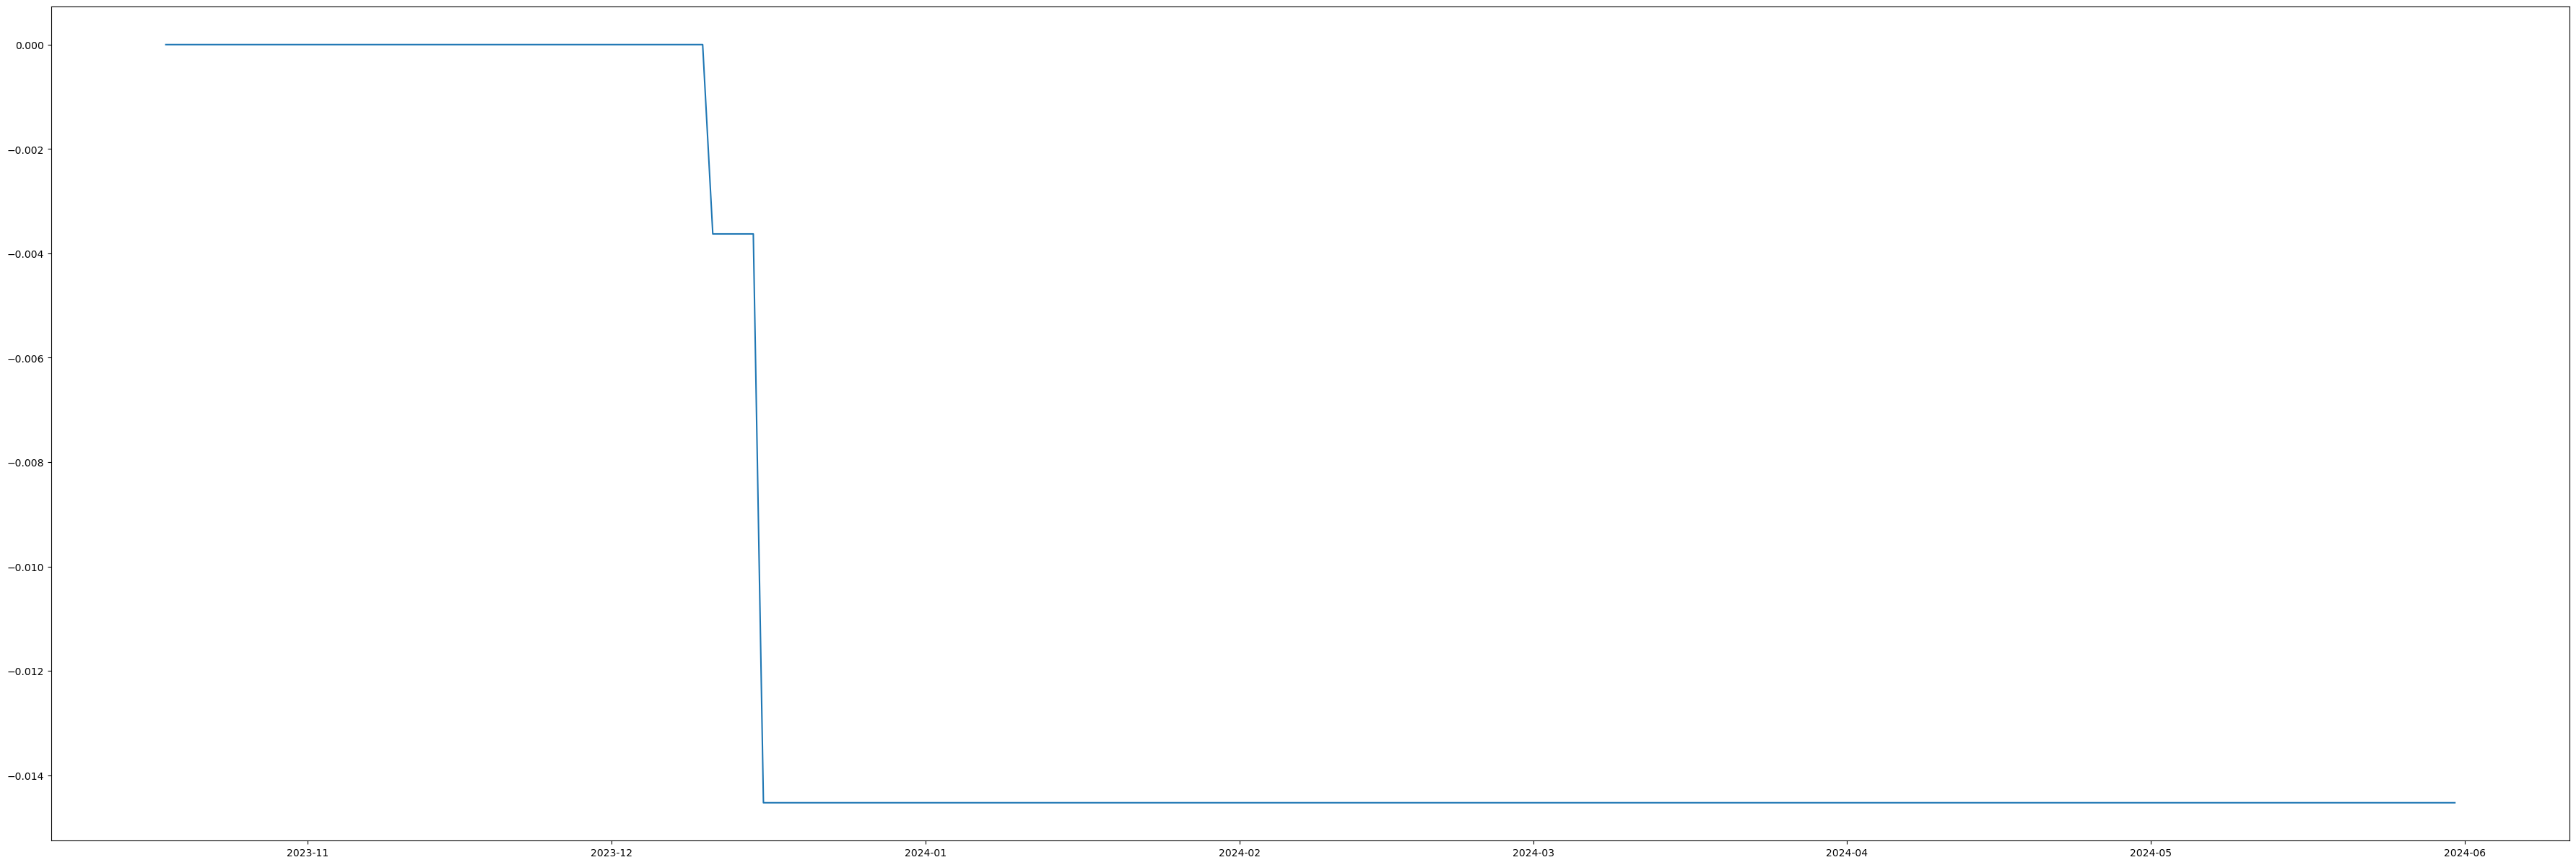

In [89]:
plt.figure(figsize=(45, 15))
plt.plot(time_series['rolling_max_drawdown'])
plt.show()

# Sharpe Analytics

In [90]:
import pandas as pd
import numpy as np
import scipy.stats as stats

# Load your trading strategy returns
# Replace 'your_returns.csv' with the actual file containing your returns data
# The returns should be in a column named 'returns'
# data = pd.read_csv('your_returns.csv')

returns = time_series[time_series['pnl_vector'] !=0]['pnl_vector']

# Calculate the Sharpe Ratio
def sharpe_ratio(returns, risk_free_rate=0.05):
    excess_returns = returns - risk_free_rate
    return np.mean(excess_returns) / np.std(excess_returns)

# Calculate the Maximum Drawdown
def max_drawdown(returns):
    cumulative_returns = (1 + returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

# Calculate Skewness
def skewness(returns):
    return stats.skew(returns)

# Calculate Kurtosis
def kurtosis(returns):
    return stats.kurtosis(returns)

# Calculate Left Tail Fatness (probability of extreme negative returns)
def left_tail_fatness(returns, threshold=-0.05):
    return np.sum(returns < threshold) / len(returns)

# Calculate Right Tail Fatness (probability of extreme positive returns)
def right_tail_fatness(returns, threshold=0.05):
    return np.sum(returns > threshold) / len(returns)

# Calculate metrics
sharpe = sharpe_ratio(returns)
max_dd = max_drawdown(returns)
skew = skewness(returns)
kurt = kurtosis(returns)
left_tail = left_tail_fatness(returns)
right_tail = right_tail_fatness(returns)

# Print metrics
print(f'Sharpe Ratio: {sharpe:.2f}')
print(f'Maximum Drawdown: {max_dd:.2%}')
print(f'Skewness: {skew:.2f}')
print(f'Kurtosis: {kurt:.2f}')
print(f'Left Tail Fatness (returns < -5%): {left_tail:.2%}')
print(f'Right Tail Fatness (returns > 5%): {right_tail:.2%}')


Sharpe Ratio: 0.96
Maximum Drawdown: -67952.93%
Skewness: nan
Kurtosis: nan
Left Tail Fatness (returns < -5%): 28.57%
Right Tail Fatness (returns > 5%): 57.14%
